In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Imports

In [3]:
import pyspark
from ifood_case.feature_engineering import FeatureEngineering
from ifood_case.model_trainer import LGBMTrainer
from ifood_case.evaluator import Evaluator
from ifood_case.utils import find_optimal_threshold
import pyspark.sql.functions as F
import warnings

In [4]:
warnings.filterwarnings('ignore')

## Initialize Spark

In [5]:
spark = pyspark.sql.SparkSession.builder.appName("ifood-case").getOrCreate()

25/09/25 16:48:05 WARN Utils: Your hostname, solid resolves to a loopback address: 127.0.0.2; using 192.168.0.39 instead (on interface enp5s0)
25/09/25 16:48:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/25 16:48:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Variables

In [6]:
OFFER_COST = 0.50 # Custo para enviar uma oferta para alguém. Sintético e simbólico

## Load Data

In [7]:
offers = spark.read.parquet("../data/processed/offers_processed")
transactions = spark.read.parquet("../data/processed/transactions_processed")
profile = spark.read.parquet("../data/processed/profile_processed")

## Modelling

### Feature Engieneering

In [8]:
fe = FeatureEngineering(offers, transactions, profile)

In [9]:
df, numerical_columns, categorical_columns = fe.transform()

In [10]:
df.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- offer_id: string (nullable = true)
 |-- time_received: double (nullable = true)
 |-- target: integer (nullable = false)
 |-- total_spend_before: double (nullable = true)
 |-- transaction_count_before: long (nullable = true)
 |-- avg_ticket_before: double (nullable = true)
 |-- max_ticket_before: double (nullable = true)
 |-- min_ticket_before: double (nullable = true)
 |-- offers_viewed_count_before: long (nullable = true)
 |-- offers_completed_count_before: long (nullable = true)
 |-- customer_conversion_rate_before: double (nullable = true)
 |-- last_offer_viewed_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: long (nullable = true)
 |-- credit_card_limit: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)
 |-- dayofweek_sin: double (nullable = true)
 |-- dayofweek_cos: double (nullable = true)
 |-- offer_type: string (nullable = true)
 |-- durati

### Model Train

In [11]:
lgbm_trainer = LGBMTrainer(df, numerical_columns, categorical_columns, "target")

In [12]:
x_train, x_test, y_train, y_test = lgbm_trainer.train()

25/09/25 16:48:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

### Model Evaluate

In [13]:
evaluator = Evaluator(x_test, y_test)

In [14]:
y_pred = lgbm_trainer.predict(x_test)

In [15]:
y_pred_proba = lgbm_trainer.predict_proba(x_test)

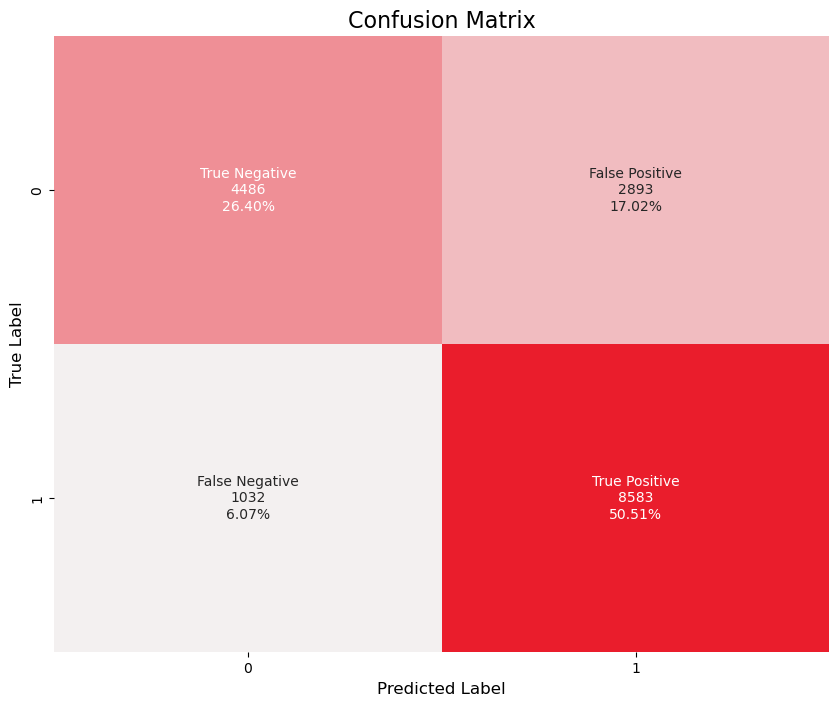

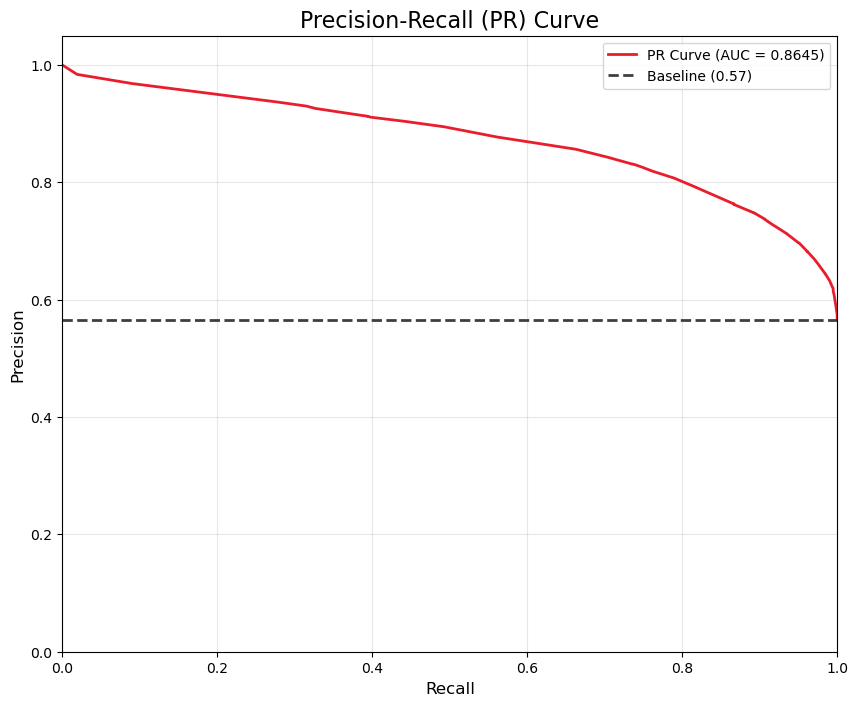

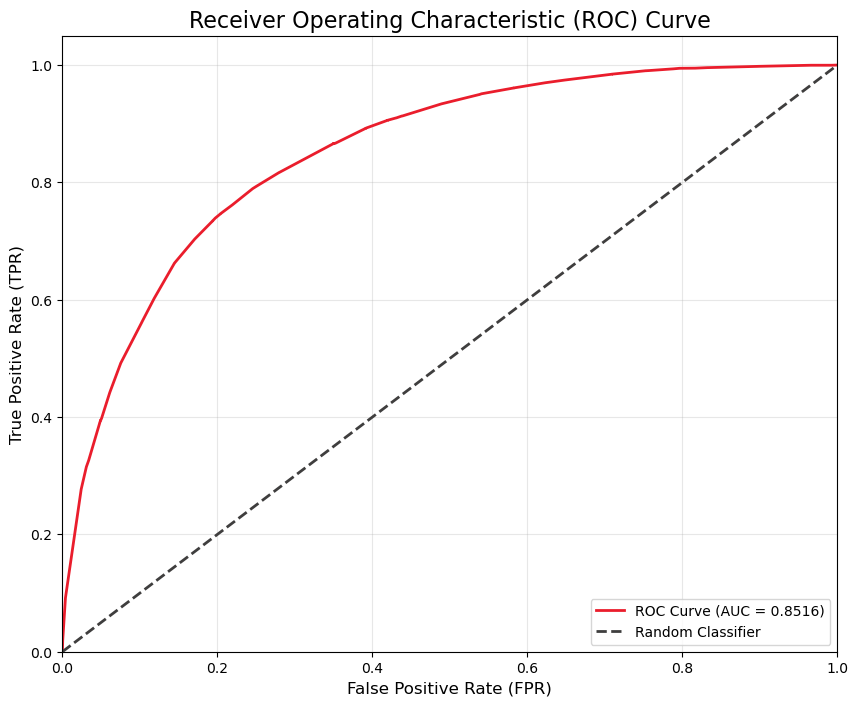

In [16]:
metrics = evaluator.report(y_pred, y_pred_proba)

In [17]:
metrics["actual_conversion_rate_test (%)"]

np.float64(56.58)

In [18]:
metrics["model_conversion_rate (%)"]

np.float64(67.53)

In [19]:
metrics["classification_report"]

{'0': {'precision': 0.813,
  'recall': 0.6079,
  'f1-score': 0.6957,
  'support': 7379.0},
 '1': {'precision': 0.7479,
  'recall': 0.8927,
  'f1-score': 0.8139,
  'support': 9615.0},
 'accuracy': 0.769,
 'macro avg': {'precision': 0.7804,
  'recall': 0.7503,
  'f1-score': 0.7548,
  'support': 16994.0},
 'weighted avg': {'precision': 0.7762,
  'recall': 0.769,
  'f1-score': 0.7626,
  'support': 16994.0}}

#### UP Lift

In [20]:
avg_conversion_value = x_train.loc[y_train == 1,:]['max_ticket_before'].mean()

In [21]:
results_df = find_optimal_threshold(evaluator, y_pred_proba, avg_conversion_value, OFFER_COST)

--- Threshold vs. Uplift Analysis ---
    threshold  model_profit  financial_uplift
0        0.05     187333.13           4790.23
1        0.10     187132.40           4589.50
2        0.15     186442.32           3899.42
3        0.20     185463.43           2920.53
4        0.25     183761.14           1218.24
5        0.30     181440.54          -1102.36
6        0.35     179439.33          -3103.57
7        0.40     172850.20          -9692.70
8        0.45     172833.33          -9709.57
9        0.50     169088.65         -13454.25
10       0.55     164250.04         -18292.86
11       0.60     155038.56         -27504.34
12       0.65     149899.29         -32643.61
13       0.70     139599.48         -42943.42
14       0.75     139559.75         -42983.15
15       0.80     125933.33         -56609.57
16       0.85     114624.06         -67918.84
17       0.90      84177.78         -98365.12
18       0.95      60069.03        -122473.87

--- Best Threshold Found ---
threshold   

### Model Explanation

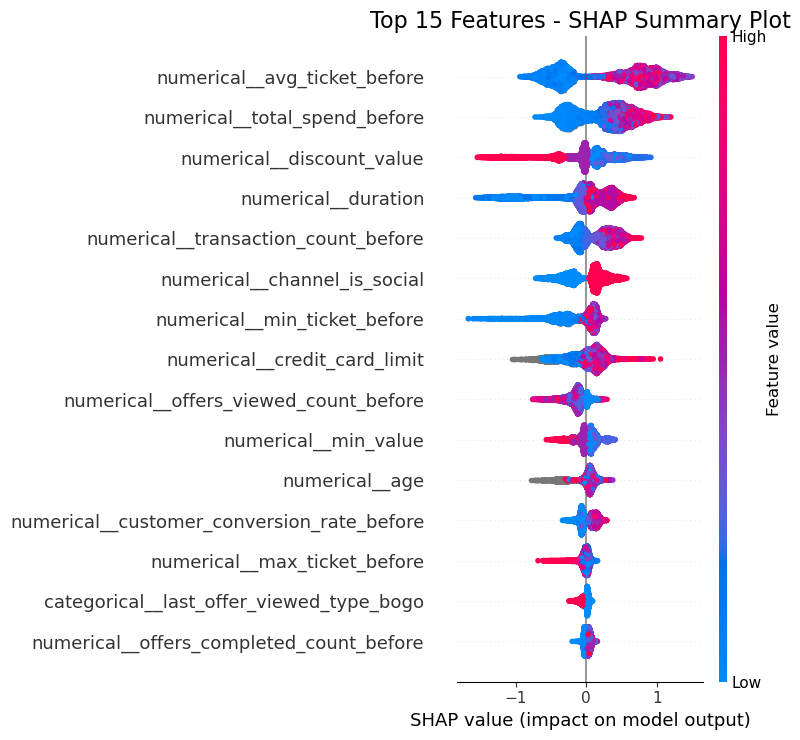

In [23]:
evaluator.plot_shap_summary(lgbm_trainer.estimator)